# Notebook to train the model
This notebook train a UNET model based on training data in /data/raw/train_features/

There are two parameters to set before starting the notebook.
- the model name
- the train test split

My approach is based on the average of three similar UNET model trained on different data.  
By choosing TRAIN_TEST_SPLIT = 1, 2 or three you train one of the three models.


Also depending on your memory you might have to change the batch_size.  
For me 8 seems to work most of the time.

In [1]:
MODEL_NAME = "test_1.h5"    #here you can choose the name of the h5 file where the model fill be saved
TRAIN_TEST_SPLIT = 1        #here you can choose the train/test split. Possible choice: 1, 2 or 3

## Importing libraries

In [ ]:
!pip install pandas_path

In [ ]:
!pip install albumentations

In [4]:
from IPython.display import HTML, display
import os
from pathlib import Path
import random

import albumentations
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
from pandas_path import path
import rasterio
from skimage.morphology import label
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
plt.style.use("ggplot")
%matplotlib inline

2021-10-19 18:57:21.314709: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Only for training on google colab

In [5]:
#tf.test.gpu_device_name()

In [6]:
#from google.colab import drive
#drive.mount('/content/drive')

In [7]:
#DATA_PATH = Path.cwd().parent / "content" / "drive" / "MyDrive" / "DATA SCIENCE" / "data google colab" / "floodwater" / "train_features"

## Load the training dataframe

In [8]:
img_size = 512

In [ ]:
# This is where our downloaded images and metadata live locally
DATA_PATH = Path.cwd().parent.parent / "data" / "raw" / "train_features"
ADDITIONAL_DATA_PATH = Path.cwd().parent.parent / "data" / "external"
train_metadata = pd.read_csv(
    DATA_PATH / "flood-training-metadata.csv", parse_dates=["scene_start"]
)

In [15]:
#adding the path to the images and labels in the dataframe
train_metadata["feature_path"] = (str(DATA_PATH / "train_features")
    / train_metadata.image_id.path.with_suffix(".tif").path)

train_metadata["change"] = (str(ADDITIONAL_DATA_PATH / "jrc_change")
    / train_metadata.chip_id.path.with_suffix(".tif").path)

train_metadata["extent"] = (str(ADDITIONAL_DATA_PATH / "jrc_extent")
    / train_metadata.chip_id.path.with_suffix(".tif").path)

train_metadata["occurrence"] = (str(ADDITIONAL_DATA_PATH / "jrc_occurrence")
    / train_metadata.chip_id.path.with_suffix(".tif").path)

train_metadata["recurrence"] = (str(ADDITIONAL_DATA_PATH / "jrc_recurrence")
    / train_metadata.chip_id.path.with_suffix(".tif").path)

train_metadata["seasonality"] = (str(ADDITIONAL_DATA_PATH / "jrc_seasonality")
    / train_metadata.chip_id.path.with_suffix(".tif").path)

train_metadata["transitions"] = (str(ADDITIONAL_DATA_PATH / "jrc_transitions")
    / train_metadata.chip_id.path.with_suffix(".tif").path)

train_metadata["nasadem"] = (str(ADDITIONAL_DATA_PATH / "nasadem")
    / train_metadata.chip_id.path.with_suffix(".tif").path)

train_metadata["label_path"] = (str(DATA_PATH / "train_labels")
    / train_metadata.chip_id.path.with_suffix(".tif").path)

## Split the training data into train and test
We split the train test dataset in three different ways depending on the model we are building.
At the end we average the prediction of the three models.

In [16]:
test_ids = [['kuo', 'wvy', 'awc'] , ['coz', 'qxb', 'ayt'] , ['hbe', 'jja']]
val_flood_ids = test_ids[TRAIN_TEST_SPLIT-1]
val_flood_ids

['kuo', 'wvy', 'awc']

In [17]:
test = train_metadata[train_metadata.flood_id.isin(val_flood_ids)]
train = train_metadata[~train_metadata.flood_id.isin(val_flood_ids)]

In [18]:
def get_paths_by_chip(image_level_df):
    """
    Function that take as input the meta_dataframe
    and return a dataframe with the chip id and both path for vv and vh.
    """
    
    paths = []
    for chip, group in image_level_df.groupby("chip_id"):
        vv_path = group[group.polarization == "vv"]["feature_path"].values[0]
        vh_path = group[group.polarization == "vh"]["feature_path"].values[0]
        nasadem_path = group["nasadem"].values[0]
        change_path = group["change"].values[0]
        extent_path = group["extent"].values[0]
        occurrence_path = group["occurrence"].values[0]
        recurrence_path = group["recurrence"].values[0]
        seasonality_path = group["seasonality"].values[0]
        transitions_path = group["transitions"].values[0]
        paths.append([chip, vv_path, vh_path, nasadem_path, change_path, extent_path, occurrence_path, recurrence_path,
                      seasonality_path, transitions_path])
    return pd.DataFrame(paths, columns=["chip_id", "vv_path", "vh_path", "nasadem_path", "change_path", "extent_path", "occurrence_path",
                                        "recurrence_path", "seasonality_path", "transitions_path"])

In [19]:
# Separate features from labels
test_meta_x = get_paths_by_chip(test)
test_meta_y = test[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

train_meta_x = get_paths_by_chip(train)
train_meta_y = train[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

In [ ]:
train_meta_x

## Get the images from the train and test metadata

In [21]:
def progress(value, max=100):
    return HTML("""
        <progress value='{value}', max='{max}', style='width: 100%'> {value} </progress>
    """.format(value=value, max=max))

In [22]:
def numpy_mask(image_path):
    with rasterio.open(image_path) as img:
        return img.read(1, masked=True)

In [23]:
def get_images(feature_path, label_path):
    features = []
    labels = []
    masks = []

    #progress bar
    out1 = display(progress(0, 100), display_id=True)
    out2 = display(progress(0, 100), display_id=True)

    paths = label_path['label_path'].to_list()
    nb_cols = len(paths)
    #load labels
    for i in range(nb_cols):
        with rasterio.open(paths[i]) as lp:
            img = lp.read(1)

        #create a list of mask for missing pixels
        mask = np.zeros(img.shape, dtype=np.uint8)
        mask[np.where(img == 255)] = 1

        labels.append(ma.array(img.astype('float32'), mask = mask))
        masks.append(mask)

        out2.update(progress((i/nb_cols)*100, 100))

    #load features
    cols = ["vv_path", "vh_path", "nasadem_path", "change_path", "extent_path", "seasonality_path", "occurrence_path", "recurrence_path", "transitions_path"]
    nb_cols = len(feature_path)
    for row in range(nb_cols) :
        images = []
        for col in cols:
            with rasterio.open(feature_path.loc[row, col]) as img:
                #load the tif file
                if (col in ["vv_path", "vh_path"]):
                    #apply transformation: clip values out of -30;0 range and map them to 0; 255 range then convert to uint8
                    images.append(ma.array(np.uint8(np.clip(img.read(1), -30, 0)*(-8.4)), mask = masks[row]))
                elif col == "nasadem_path":
                    #clip values > 255 and converto to uint8
                    images.append(ma.array(np.uint8(np.clip(img.read(1), 0, 255)), mask = masks[row]))
                else:
                    #no transformation, values are already between 0 and 255 and in uint8 format
                    images.append(ma.array(img.read(1), mask = masks[row]))
               #apply the mask
               #img = ma.array(img, mask = masks[row])
               #stack the images in one array
               #images.append(img)
        features.append(np.stack(images, axis=-1))
        out2.update(progress((row/nb_cols)*100, 100))       
            
    return np.array(features), np.array(labels)

In [24]:
train_x, train_y = get_images(train_meta_x, train_meta_y)
test_x, test_y = get_images(test_meta_x, test_meta_y)

In [25]:
(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

((430, 512, 512, 9), (430, 512, 512), (112, 512, 512, 9), (112, 512, 512))

## Image augmentation

In [26]:
random.seed(0)

transform = albumentations.Compose(
    [
        #albumentations.RandomCrop(256, 256),
        albumentations.RandomRotate90(),
        albumentations.HorizontalFlip(),
        albumentations.VerticalFlip(),
    ]
)

In [27]:
train_x_aug = []
train_y_aug = []
for i in range(len(train_x)):
    t = transform(image=train_x[i], mask=train_y[i])
    train_x_aug.append(t['image'])
    train_y_aug.append(t['mask'])

train_x_aug = np.array(train_x_aug)
train_y_aug = np.array(train_y_aug)

In [28]:
train_x_aug.shape

(430, 512, 512, 9)

## Display the images and the corresponding augmented image

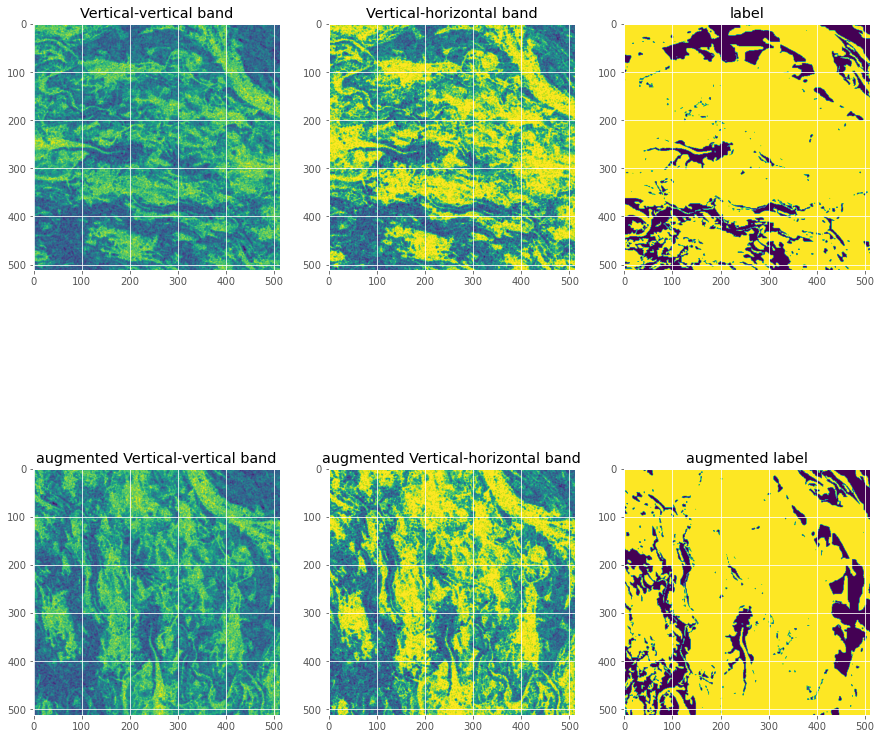

In [29]:
f, ax = plt.subplots(2, 3, figsize=(15, 15))

id = 2
#visualize radar image
ax[0][0].imshow(train_x[id, :, :, 0])
ax[0][0].set_title("Vertical-vertical band")

ax[0][1].imshow(train_x[id, :, :, 1])
ax[0][1].set_title("Vertical-horizontal band")

ax[0][2].imshow(train_y[id])
ax[0][2].set_title("label")

ax[1][0].imshow(train_x_aug[id, :, :, 0])
ax[1][0].set_title("augmented Vertical-vertical band")

ax[1][1].imshow(train_x_aug[id, :, :, 1])
ax[1][1].set_title("augmented Vertical-horizontal band")

ax[1][2].imshow(train_y_aug[id])
ax[1][2].set_title("augmented label")

plt.show()

# Concatenate training data and augmented data

In [30]:
train_x_final = np.concatenate((train_x, train_x_aug))
train_y_final = np.concatenate((train_y, train_y_aug))

In [31]:
(train_x_final.shape, train_y_final.shape)

((860, 512, 512, 9), (860, 512, 512))

# Define loss function

In [32]:
# https://gist.github.com/wassname/7793e2058c5c9dacb5212c0ac0b18a8a
def DiceLoss_square(y_true, y_pred, smooth=1):
    #create the missing data mask
    mask = tf.math.not_equal(y_true, 255)
    #apply the mask
    y_true = tf.boolean_mask(y_true, mask)
    y_pred = tf.boolean_mask(y_pred, mask)
  
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(K.abs(y_true_f * y_pred_f))
    return 1-((2. * intersection + smooth) / (K.sum(K.square(y_true_f),-1) + K.sum(K.square(y_pred_f),-1) + smooth))

def DiceLoss(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return 1-((2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth))

In [33]:
def IOU_coef(y_true, y_pred):
    #create the missing data mask
    mask = tf.math.not_equal(y_true, 255)
    #apply the mask
    y_true = tf.boolean_mask(y_true, mask)
    y_pred = tf.boolean_mask(y_pred, mask)

    #make all values > 0.5 a 1 and all others a 0
    y_pred = tf.cast((y_pred > 0.5), dtype=tf.float32)
    #y_pred = tf.math.multiply(tf.math.greater(y_pred, 0.5),1.0)

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

# https://www.youtube.com/watch?v=BNPW1mYbgS4
def IOULoss(y_true, y_pred):
    return -IOU_coef(y_true, y_pred)

# Unet model

In [34]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [35]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
input_img = Input((img_size, img_size, 9), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss=DiceLoss_square, metrics=[IOU_coef])
model.summary()

In [37]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('../../models/temporary/' + MODEL_NAME, verbose=1, save_best_only=True, save_weights_only=False)
]

In [38]:
print(type(train_x_final[0,0,0,8]), type(train_y[0,0,0]))
print(type(test_x[0,0,0,0]), type(test_y[0,0,0]))

<class 'numpy.uint8'> <class 'numpy.float32'>
<class 'numpy.uint8'> <class 'numpy.float32'>


In [39]:
print("max train_x:", np.amax(train_x), "min train_x:", np.amin(train_x))
print("max train_x_aug:", np.amax(train_x_aug), "min train_x_aug:", np.amin(train_x_aug))
print("max test_x:", np.amax(test_x), "min test_x:", np.amin(test_x))
print("max train_y:", np.amax(train_y), "min train_y:", np.amin(train_y))
print("max test_y:", np.amax(test_y), "min test_y:", np.amin(test_y))

max train_x: 255 min train_x: 0
max train_x_aug: 255 min train_x_aug: 0
max test_x: 255 min test_x: 0
max train_y: 255.0 min train_y: 0.0
max test_y: 255.0 min test_y: 0.0


In [ ]:
results = model.fit(train_x_final, train_y_final, batch_size=8, epochs=100, callbacks=callbacks,
                    validation_data=(test_x, test_y))

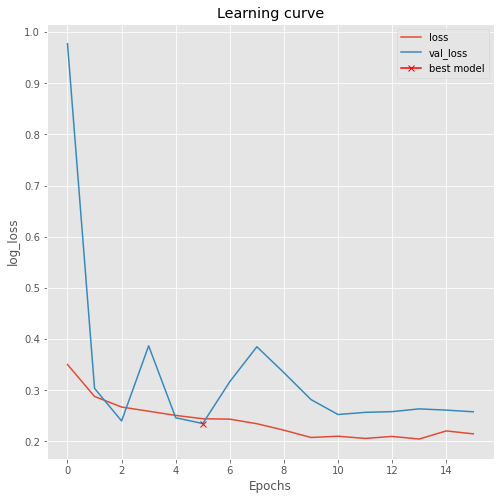

In [41]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();